In [ ]:
import pandas as pd
import gensim as gs
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim



import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string
from nltk.stem.wordnet import WordNetLemmatizer
import warnings
warnings.simplefilter('ignore')
from itertools import chain




In [ ]:
!pip install pyLDAvis==3.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.8 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv('/content/reviews_data.csv')
df.head(5)

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [ ]:
df.shape

(850, 6)

In [ ]:
#to check missing values

df.isnull().sum()


name             0
location         0
Date             0
Rating         145
Review           0
Image_Links      0
dtype: int64

In [ ]:
#code for removing missing values in rating column

df = df.dropna(subset=['Rating'])


In [ ]:
df.isnull().sum()

name           0
location       0
Date           0
Rating         0
Review         0
Image_Links    0
dtype: int64

In [ ]:
columns_to_drop = ['name', 'location', 'Date', 'Rating', 'Image_Links']
df = df.drop(columns_to_drop, axis=1)
df

,Review
0,Amber and LaDonna at the Starbucks on Southwes...
1,** at the Starbucks by the fire station on 436...
2,I just wanted to go out of my way to recognize...
3,Me and my friend were at Starbucks and my card...
4,I’m on this kick of drinking 5 cups of warm wa...
...,...
700,I ordered Via Starbucks coffee online. I recei...
701,"My name is Ric **, I am journalist by professi..."
702,"The bagel was ice cold, not cut and not toasted."
703,"In the morning of Monday, August 15, 2011, at ..."


In [ ]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Preprocess function
def preprocess_text(text):
    text = text.lower()
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    words = [word for word in words if word.isalpha()]
    return words



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Preprocess the documents
documents = df['Review'].tolist()
processed_docs = [preprocess_text(doc) for doc in documents]

# Count word frequencies
all_words = [word for doc in processed_docs for word in doc]
word_freq = Counter(all_words)

# Display the 10 most common words
most_common_words = word_freq.most_common(50)
print(most_common_words)

[('starbucks', 1052), ('coffee', 595), ('customer', 286), ('one', 279), ('get', 276), ('drink', 275), ('store', 259), ('service', 256), ('time', 237), ('like', 224), ('order', 218), ('said', 217), ('go', 214), ('would', 213), ('card', 197), ('went', 180), ('asked', 164), ('back', 163), ('told', 159), ('ordered', 150), ('never', 147), ('got', 143), ('always', 142), ('manager', 137), ('could', 132), ('cup', 131), ('even', 126), ('customers', 124), ('day', 118), ('location', 114), ('money', 114), ('employees', 113), ('people', 109), ('going', 107), ('good', 103), ('way', 102), ('drinks', 101), ('times', 99), ('make', 98), ('every', 98), ('know', 92), ('give', 91), ('years', 91), ('new', 89), ('made', 88), ('milk', 87), ('first', 86), ('two', 86), ('morning', 85), ('want', 85)]


In [ ]:
# Create Dictionary
dictionary = corpora.Dictionary(processed_docs)

# Create Corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

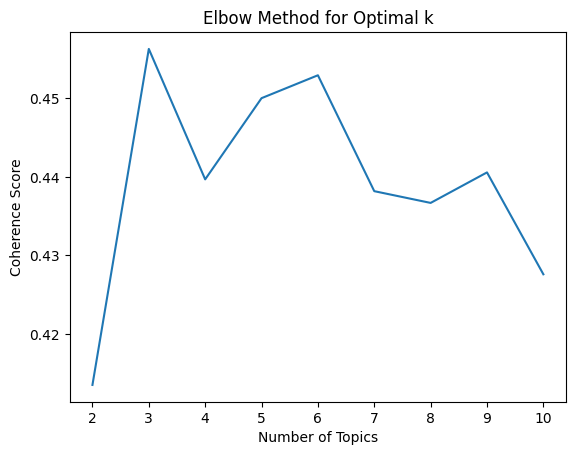

In [ ]:
#code for elbow method for identifying number of topics in topic modelling

# Elbow Method for Optimal Number of Topics
coherence_values = []
num_topics_range = range(2, 11)

for num_topics in num_topics_range:
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=20)
    coherence_model = CoherenceModel(model=model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

# Plot the coherence scores
import matplotlib.pyplot as plt

plt.plot(num_topics_range, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Elbow Method for Optimal k")
plt.show()


In [ ]:
# Create a dictionary and corpus
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Train the LDA model
num_topics = 4
lda_model = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=num_topics,
                       random_state=100,
                       chunksize=100,
                       passes=10,
                       per_word_topics=True)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print('docu: {} \nWords: {}'.format(idx, topic))


docu: 0 
Words: 0.040*"starbucks" + 0.015*"card" + 0.013*"coffee" + 0.011*"customer" + 0.009*"service" + 0.008*"would" + 0.007*"one" + 0.007*"get" + 0.007*"like" + 0.006*"always"
docu: 1 
Words: 0.018*"starbucks" + 0.009*"one" + 0.009*"said" + 0.009*"store" + 0.009*"customer" + 0.008*"manager" + 0.008*"order" + 0.008*"service" + 0.007*"asked" + 0.007*"time"
docu: 2 
Words: 0.025*"coffee" + 0.017*"starbucks" + 0.013*"drink" + 0.011*"review" + 0.011*"text" + 0.010*"ordered" + 0.009*"cup" + 0.009*"one" + 0.009*"store" + 0.007*"said"
docu: 3 
Words: 0.017*"starbucks" + 0.014*"coffee" + 0.006*"drink" + 0.005*"much" + 0.005*"began" + 0.005*"home" + 0.004*"one" + 0.004*"around" + 0.003*"love" + 0.003*"great"


In [ ]:
#topic word matrix code
topic_word_matrix = lda_model.get_topics()

# Print the shape of the matrix
print("Shape of topic-word matrix:", topic_word_matrix.shape)

# Access individual topic-word distributions
for topic_idx in range(num_topics):
    top_words = topic_word_matrix[topic_idx, :].argsort()[::-1][:10]
    print(f"topic {topic_idx}: {[dictionary[word_idx] for word_idx in top_words]}")


Shape of topic-word matrix: (4, 5489)
topic 0: ['starbucks', 'card', 'coffee', 'customer', 'service', 'would', 'one', 'get', 'like', 'always']
topic 1: ['starbucks', 'one', 'said', 'store', 'customer', 'manager', 'order', 'service', 'asked', 'time']
topic 2: ['coffee', 'starbucks', 'drink', 'review', 'text', 'ordered', 'cup', 'one', 'store', 'said']
topic 3: ['starbucks', 'coffee', 'drink', 'much', 'began', 'home', 'one', 'around', 'love', 'great']


In [ ]:
#document topic matrix

doc_topic_matrix = lda_model.get_document_topics(corpus)

doc_topic_df = pd.DataFrame(doc_topic_matrix, columns=[f'douc {i}' for i in range(num_topics)])
print(doc_topic_df)


              douc 0           douc 1            douc 2            douc 3
0     (0, 0.7447161)  (1, 0.23487253)  (2, 0.010558089)              None
1    (1, 0.72716016)   (3, 0.2618861)              None              None
2    (1, 0.77108204)  (2, 0.21369438)              None              None
3    (0, 0.69426984)  (1, 0.29079303)              None              None
4    (0, 0.41876617)  (2, 0.56715286)              None              None
..               ...              ...               ...               ...
845  (2, 0.97172123)             None              None              None
846  (0, 0.08333491)  (1, 0.08333492)    (2, 0.7499941)  (3, 0.083336085)
847  (0, 0.01694738)  (1, 0.94912314)  (2, 0.017141124)  (3, 0.016788356)
848  (0, 0.08333491)  (1, 0.08333492)   (2, 0.74999404)  (3, 0.083336085)
849  (0, 0.08333491)  (1, 0.08333492)    (2, 0.7499941)  (3, 0.083336085)

[850 rows x 4 columns]


In [ ]:
coherence_scores = []
num_topics_range = range(2, 11)

for num_topics in num_topics_range:
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=20)
    coherence_model = CoherenceModel(model=model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_values.append(coherence_score)
    print(f"Number of topics: {num_topics}, Coherence Score: {coherence_score:.4f}")


Number of topics: 2, Coherence Score: 0.4135
Number of topics: 3, Coherence Score: 0.4563
Number of topics: 4, Coherence Score: 0.4397
Number of topics: 5, Coherence Score: 0.4500
Number of topics: 6, Coherence Score: 0.4529
Number of topics: 7, Coherence Score: 0.4382
Number of topics: 8, Coherence Score: 0.4367
Number of topics: 9, Coherence Score: 0.4406
Number of topics: 10, Coherence Score: 0.4276


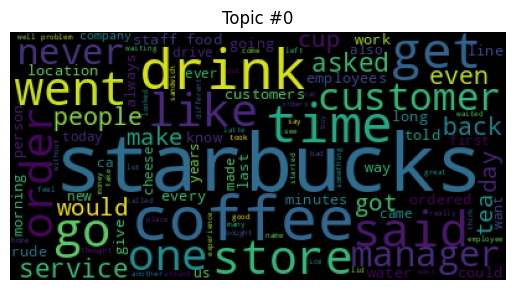

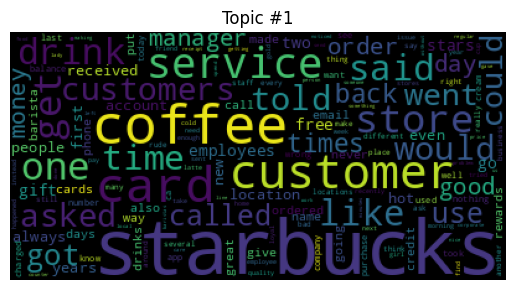

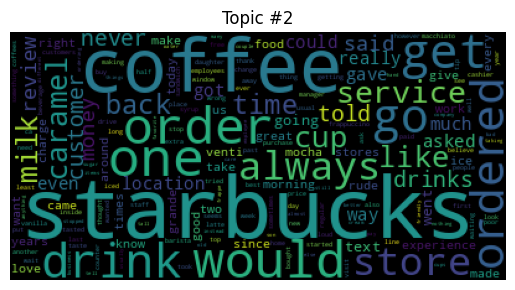

In [ ]:
# Generate word clouds for each topic
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()
